In [1]:
chan_index = int(input('Enter channel index to analyze:'))
# print('Enter Open Ephys data directory path:')
# source_path = raw_input()

Enter channel index to analyze:5


In [2]:
source_path = '../data/OpenEphys_data/2019-04-26/2019-04-26_12-03-55'

In [3]:
import time
t0 = time.time()
import OpenEphys
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import scipy.signal

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
f_names = []
for root, dirnames, filenames in os.walk(source_path):
    for filename in filenames:
        f_regex = re.compile(r".*CH(\d|\d\d)\.continuous$")
        if f_regex.match(filename):
            f_names = f_names + [os.path.join(root, filename)]
f_names = np.array(f_names)
chans = [int(f.split('.')[-2].split('_')[-1][2:]) for f in f_names]
f_names = f_names[np.argsort(chans)] # now sorted by channel number

In [7]:
chan_data = []
for contact in range(7):
    contact_reps = []
    for i in range(contact*4, contact*4 + 4):
        print('Reading {}...'.format(f_names[i]))
        file_content = OpenEphys.load(f_names[i])
        Fs = float(file_content['header']['sampleRate'])
        signal_filtered = butter_bandpass_filter(file_content['data'], 200, 3000, Fs, order=2 )
        contact_reps.append(signal_filtered)
    contact_reps = np.array(contact_reps)
    chan_data.append(np.mean(contact_reps, axis=0))
    print('-----------------------------------------------')
chan_data = np.array(chan_data)
contact_reps = None

Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH1.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH2.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH3.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH4.continuous...
Loading continuous data...
-----------------------------------------------
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH5.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH6.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH7.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH8.continuous...
Loading continuous data...
-----------------------------------------------
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH9.continuous...
Loading continuous data...
Read

In [8]:
common_avg_ref(chan_data)
chan_data = scipy.signal.detrend(chan_data)

chan_filtered_fname = os.path.join(source_path, 'channels_filtered.npy')
print('Saving filtered data to {}'.format(chan_filtered_fname))
np.save(chan_filtered_fname, chan_data)

Saving filtered data to ../data/OpenEphys_data/2019-04-11_13-02-56/channels_filtered.npy


In [6]:
chan_filtered_fname = os.path.join(source_path, 'channels_filtered.npy')
chan_data = np.load(chan_filtered_fname)
Fs = 30000.0

### Plot channel voltage

In [35]:
chan_index = int(input('Enter channel index to analyze:'))
# print('Enter Open Ephys data directory path:')
# source_path = raw_input()

Enter channel index to analyze:0


<IPython.core.display.Javascript object>


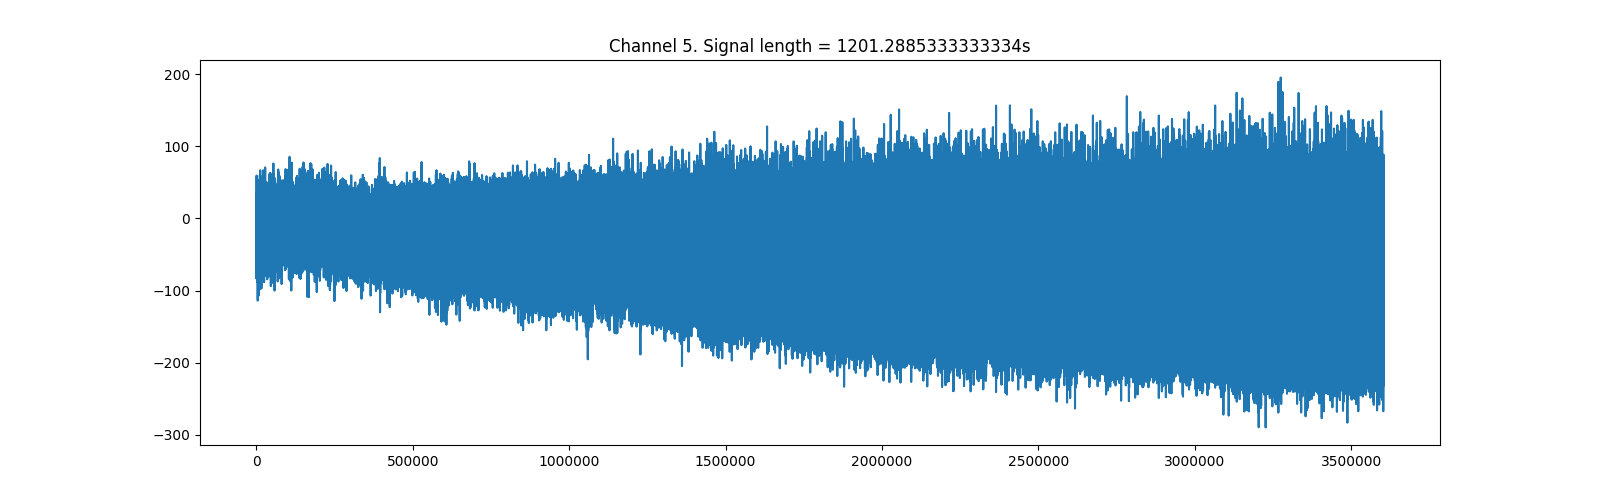

Text(0.5, 1.0, 'Channel 5. Signal length = 1201.2885333333334s')

In [90]:
# plot channel
plt.figure(figsize=(16,5))
plt.plot(chan_data[chan_index,::10])
plt.title('Channel {}. Signal length = {}s'.format(chan_index, chan_data.shape[1]/Fs))

In [94]:
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(chan_data[chan_index, :], dt)
css.num_gmm_components = 5
css.cs_num_gmm_components = 12
css.pre_window = 0.0001
css.post_window = 0.0025
css.run(use_filtered=False, remove_overlap=False, spike_detection_dir = 'min', align_spikes_to='min')

[autoreload of cssorter.spikesorter failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPyt

Pre-process...
Using minibatch spike detection, batch size = 50s, using filter (derivative) is False
Using spikes min for detection. Aligning them to their min. 
Spike detection time = 58.491339683532715
Using all spikes for alignment (no overlap removal)
Align spikes time = 0.21625947952270508
Clustering complex spikes...
Splitting detected spikes for CS clustering ...
CS spike detection time = 19.448492288589478
Merging overlapping CS waveforms
CS post process time = 0.0054721832275390625


In [95]:
css.cs_indices.shape

(2815,)

In [104]:
csiss = np.diff(css.cs_indices)
new_cs = np.delete(css.cs_indices, np.where(csiss < 0.010/css.dt)[0]+1)
print(new_cs.shape)

(376,)


In [8]:
css._align_spikes(remove_align_overlaps=False)

Using all spikes for alignment (no overlap removal)


In [24]:
orig_cs_idnices = css.cs_indices
css.cs_indices = css._remove_overlapping_complex_spikes()


Merging overlapping CS waveforms


(2388,)

In [40]:
css.cs_indices = orig_cs_idnices

In [92]:
css._realign_complex_spikes()

[autoreload of cssorter.spikesorter failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPyt

In [74]:
num_clusters = 8
pre_time = 0.0005
post_time = 0.0030
print(css.cs_indices.shape)
clusters, cluster_labels = css.cluster_detected_cs(num_clusters=num_clusters, pre_time=pre_time, post_time=post_time, align_to='min')

ss_indices = css.get_ss_indices()

(2916,)


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [75]:
ss_indices.shape

(76593,)

In [76]:
import random
pre_index = int(np.round(pre_time/css.dt))
post_index = int(np.round(post_time/css.dt))
aligned_ss = np.array([css.voltage[i - pre_index : i + post_index] for i in ss_indices[1:-2]])
mean_ss = np.mean(aligned_ss[random.sample(range(0, aligned_ss.shape[0]), css.cs_indices.size), ], axis=0)

In [77]:
t1 = time.time()
print('Total run time = {} s'.format(t1-t0))

Total run time = 2336.8375260829926 s


<IPython.core.display.Javascript object>


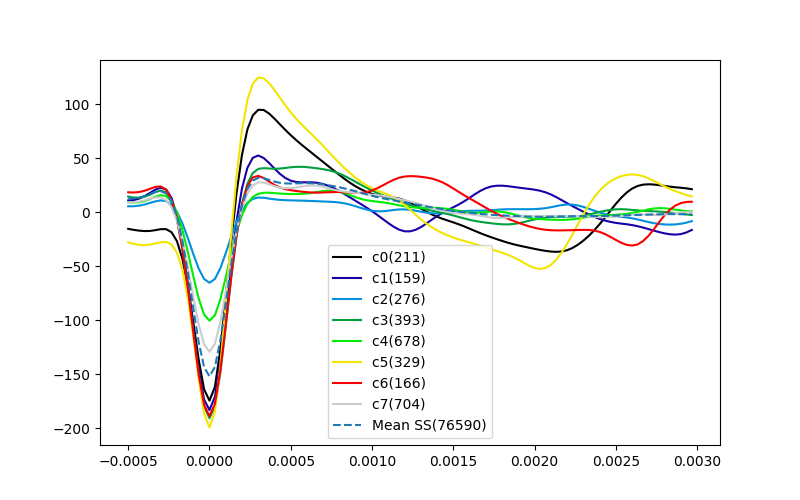

In [78]:
# plot cluster means
import matplotlib.pyplot as plt

colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters))
legend_labels = []
for cn in np.arange(num_clusters):
    legend_labels.append('c{}({}) '.format(cn, clusters[cn].shape[0]))

import gc
gc.collect()
plt.figure(figsize=(8,5))
clust_means = []
paxes = []
for cn in np.arange(num_clusters):
    clust_means.append(np.mean(clusters[cn], axis=0))
    ax = plt.plot(np.arange(-pre_index,post_index)*css.dt, clust_means[-1], color = colors[cn], label = legend_labels[cn])
    paxes.append(ax)
plt.plot(np.arange(-pre_index,post_index)*css.dt, mean_ss, '--', label = 'Mean SS({})'.format(aligned_ss.shape[0]))
# plt.xticks(plt.xticks()[0], plt.xticks()[0]*css.dt)
plt.legend() 

In [70]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(clust_means)
cs_clust = np.argmax(np.sum(np.abs(kmeans.cluster_centers_), axis=1))
clusters_to_pick = np.where(kmeans.labels_ == cs_clust)[0]
print('Detected CS clusters: {}'.format(clusters_to_pick))

Detected CS clusters: [3]


In [79]:
ans = input("Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: ")
ans_regex = re.compile(r'\d+(?:,\d+)?')
if ans_regex.match(ans):
    clusters_to_pick = [int(c) for c in ans.split(',')]
    

Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: 0,5


In [80]:
cs_indices_to_pick = []
for cti in clusters_to_pick:
    cs_indices_to_pick = np.union1d(cs_indices_to_pick, css.cs_indices[np.where(cluster_labels == cti)])
cs_indices = cs_indices_to_pick.astype(np.int64)
# ss_indices = np.setdiff1d(css.spike_indices, cs_indices)
print('Number of detected CS: {}'.format(cs_indices.shape))

Number of detected CS: (540,)


In [84]:
pre_index = int(0.002*Fs)
post_index = int(0.002*Fs)
num_clusters_2nd = 12
aligned_cs = []
aligned_cs_indices = []
for i in cs_indices:
    cs_idx = np.argmin(css.voltage[i - int(0.0005*Fs) : i + int(0.002*Fs)])+i
    aligned_cs_indices.append(cs_idx)
    aligned_cs.append(css.voltage[cs_idx - pre_index : cs_idx + post_index])

aligned_cs = np.array(aligned_cs)
aligned_cs_indices = np.array(aligned_cs_indices)

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(num_clusters_2nd, covariance_type = 'full').fit(aligned_cs)
cluster_labels_2nd = gmm.predict(aligned_cs)
clusters_2nd = []
for cn in np.arange(gmm.n_components):
    clusters_2nd.append(aligned_cs[np.where(cluster_labels_2nd == cn)])


In [96]:
clusters_2nd[0]

array([  78.83954562,   83.14502164,   80.16096685,   72.52415371,
         64.05901365,   57.93619941,   55.48700244,   56.31759777,
         58.9793237 ,   61.18058251,   59.77129968,   51.45829176,
         34.55195381,   11.10844979,  -12.74872896,  -30.83206946,
        -42.56158827,  -53.12238786,  -66.55125853,  -79.60308531,
        -84.06618478,  -75.13667085,  -56.21256389,  -35.59497517,
        -20.43229488,  -14.17182372,  -17.46873199,  -29.27237378,
        -46.87320914,  -66.17851831,  -82.94807538,  -93.99817689,
        -97.46298518,  -92.39754709,  -78.57720136,  -57.11102827,
        -31.67329787,   -9.20590458,    1.24275327,   -8.1427153 ,
        -40.04809875,  -90.55936212, -151.16564308, -211.54772659,
       -260.77842292, -288.42172249, -287.598462  , -258.39919992,
       -208.20704925, -148.23162603,  -89.02275264,  -37.99901775,
          0.86457795,   26.80472989,   41.70941396,   48.87686494,
         51.85773221,   53.9720204 ,   58.20320458,   66.96021

In [85]:
clusters[1].shape

(890, 120)

<IPython.core.display.Javascript object>


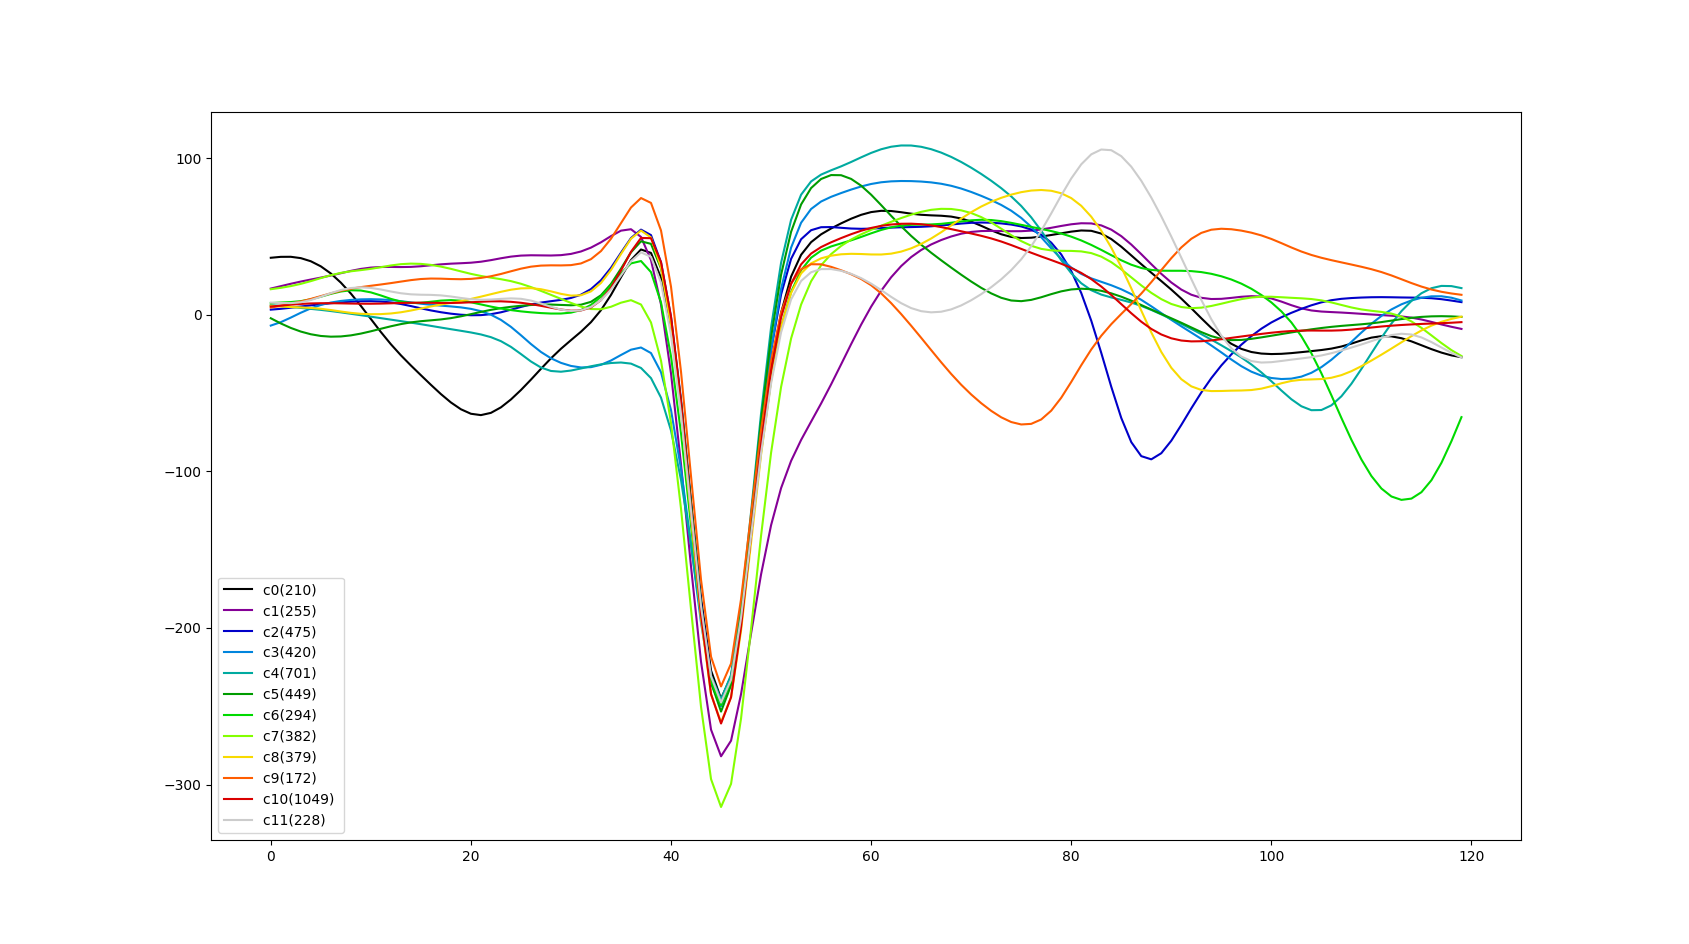

In [86]:
# plot cluster means
colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters_2nd))
legend_labels = []
for cn in np.arange(num_clusters_2nd):
    legend_labels.append('c{}({}) '.format(cn, clusters_2nd[cn].shape[0]))

import gc
gc.collect()
plt.figure(figsize=(8,5))
clust_means = []
paxes = []
for cn in np.arange(num_clusters_2nd):
    clust_means.append(np.mean(clusters_2nd[cn], axis=0))
    ax = plt.plot(clust_means[-1], color = colors[cn], label = legend_labels[cn])
    paxes.append(ax)
plt.legend()

In [89]:
clusters_to_pick = [3,4]
cs_indices_to_pick = []
for cti in clusters_to_pick:
    cs_indices_to_pick = np.union1d(cs_indices_to_pick, css.cs_indices[np.where(cluster_labels_2nd == cti)])
cs_indices_2nd = cs_indices_to_pick.astype(np.int64)
print('Number of detected CS: {}'.format(cs_indices_2nd.shape))

Number of detected CS: (1121,)


In [101]:
css.cs_indices[np.where(cluster_labels_2nd == cti)][-1]


47090128

In [105]:
css.cs_indices[-1]/30000.0

1841.8356

## Saving detected CS and SS:

In [ ]:
CS_csv_filename = os.path.join(source_path, 'channel_{}.CS.csv'.format(chan_index))
SS_csv_filename = os.path.join(source_path, 'channel_{}.SS.csv'.format(chan_index))

import csv
with open(CS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(CS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(cs_indices.reshape(-1,1))
    
with open(SS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(SS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(ss_indices.reshape(-1,1))

In [179]:
from scipy.io import loadmat
data = loadmat('../data/OpenEphys_data/2019-04-15_16-07-46/101_CH1_sorted_ehsan.mat')
cs_indices_ehsan = np.squeeze(data['CS_data']['CS_ind'][0][0])

<IPython.core.display.Javascript object>


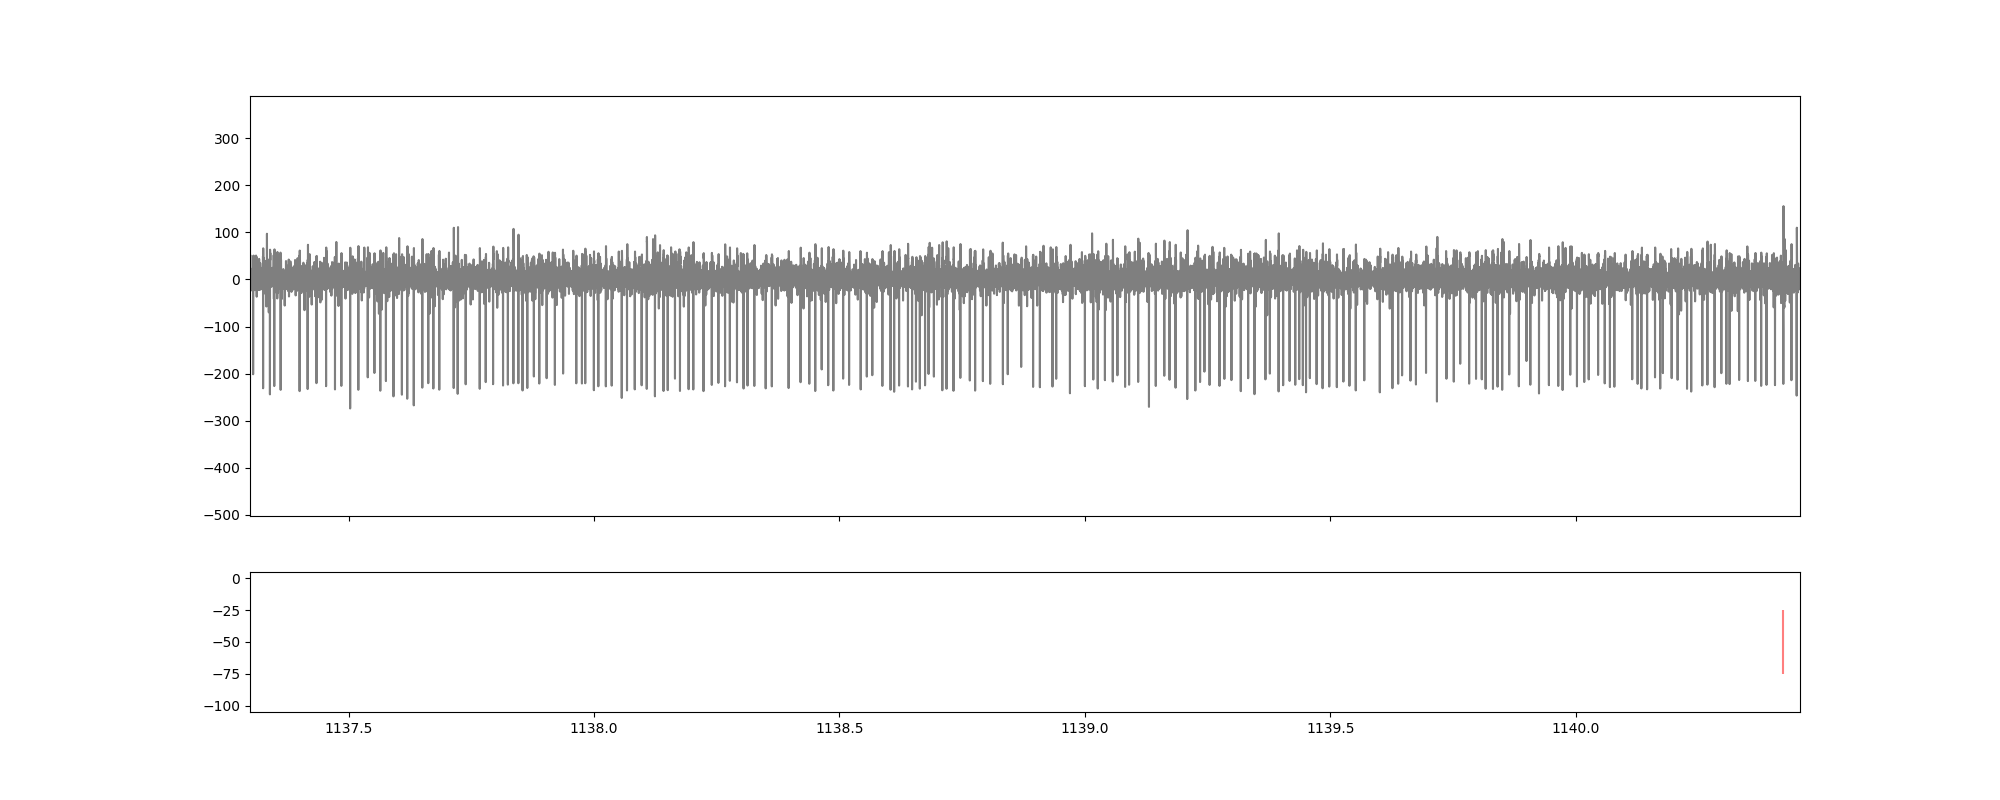

In [89]:
# plt.plot(chan_data_raw[chan_index,:], alpha = 0.5)

# plt.plot(chan_data[chan_index,:], alpha = 0.8)
# plt.subplot(212, sharex=ax1)
# plt.eventplot(cs_indices, linelengths=50, colors='r', alpha=0.5)
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,8), sharex=True)

prange = [css.signal_size*css.dt - 100, css.signal_size*css.dt] #s
# prange = [100,150] #s
idx_voltage = [int(pr*Fs) for pr in prange]
# ax1 = plt.subplot(211)
ax0.plot(np.arange(prange[0],prange[1],1/Fs), css.voltage[idx_voltage[0]: idx_voltage[1]], alpha=0.5, color='k')
# plt.subplot(212)
# ax1.eventplot(css.spike_indices[np.where(np.logical_and(css.spike_indices < idx_voltage[1] , css.spike_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=50, color='k')
# ss_indices = css.get_spike_indices()
# plt.eventplot(ss_indices[np.where(np.logical_and(ss_indices < idx_voltage[1]+ 1 , ss_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=0, color='b')

# ax1.eventplot(css.cs_indices[np.where(np.logical_and(css.cs_indices < idx_voltage[1] , css.cs_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=0, color='g')
ax1.eventplot(cs_indices[np.where(np.logical_and(cs_indices < idx_voltage[1] , cs_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=-50, color='r', alpha = 0.5)
# ax1.eventplot(cs_indices_ehsan[np.where(np.logical_and(cs_indices_ehsan < idx_voltage[1] , cs_indices_ehsan >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=-100, color='m')
# ax1.eventplot(cs_indices_2nd[np.where(np.logical_and(cs_indices_2nd < idx_voltage[1] , cs_indices_2nd >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=-50, color='r', alpha = 0.5)



In [87]:
css.signal_size*css.dt

1201.2885333333334

(50,)

In [44]:
def cs_xcorr(ss_times, cs_times, window=20):
    xcor_vect = np.zeros(2*(window) + 1)
    for csi in cs_indices:
        
        

SyntaxError: unexpected EOF while parsing (<ipython-input-44-a27ed00e1f24>, line 5)

In [47]:
SS = np.zeros(np.int64(css.signal_size/30.0))
SS[np.int64(ss_indices/30.0)] = 1
CS = np.zeros(np.int64(css.signal_size/30.0))
CS[np.int64(cs_indices/30.0)] = 1

<IPython.core.display.Javascript object>


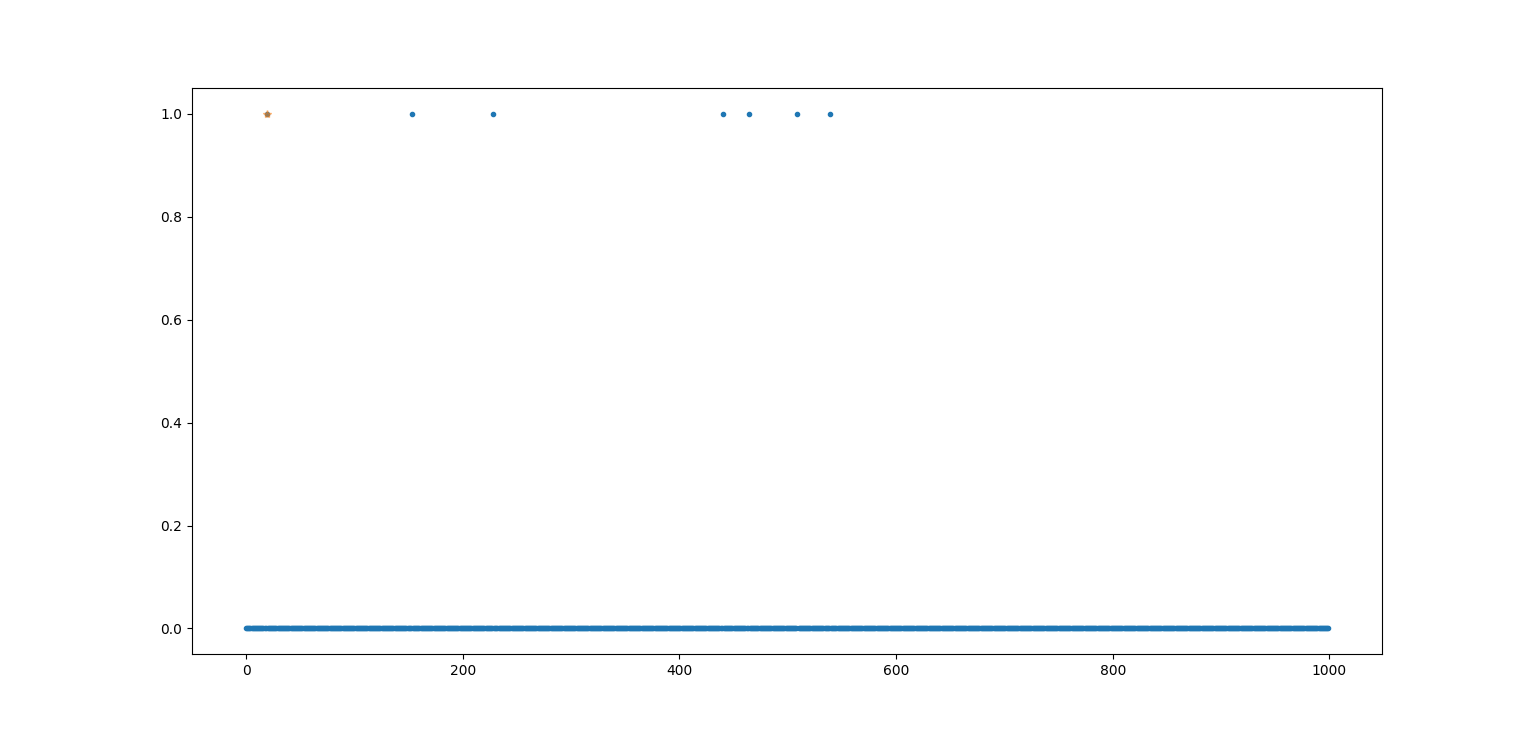

In [53]:
plt.figure()
plt.plot(SS[0:1000], '.')
plt.plot(ss_indices[0]/30,1, '*', alpha = 0.5)

In [45]:
ss_times = ss_indices/Fs
cs_times = cs_indices/Fs
window = 25
xcor_vect = np.zeros(2*window + 1)
# for cst in cs_indices:
cst = cs_indices[0]
np.where(np.logical_and(ss_times <= cst + window, ss_times >= cs))




In [ ]:
def cs_ss_corr(cs_indices, ss_indices, window, signal_size, Fs):
    SS = np.zeros(np.int64(css.signal_size/30.0))
    SS[np.int64(ss_indices/30.0)] = 1
    CS = np.zeros(np.int64(css.signal_size/30.0))
    CS[np.int64(cs_indices/30.0)] = 1
    xcor_vect = np.zeros((2*window + 1))
    for cti in np.int64(cs_indices/30.0):
        xcor_vect = xcor_vect + SS[cti-window : cti + window + 1]
    

In [72]:
SS = np.zeros(np.int64(css.signal_size/30.0))
SS[np.int64(ss_indices/30.0)] = 1
CS = np.zeros(np.int64(css.signal_size/30.0))
CS[np.int64(cs_indices/30.0)] = 1

In [73]:

window = 25
xcor_vect = np.zeros((2*window + 1))
for cti in np.int64(cs_indices/30.0):
    xcor_vect = xcor_vect + SS[cti-window : cti + window + 1]

In [74]:
window = 25
acor_vect = np.zeros((2*window + 1))
for sti in np.int64(ss_indices[10:-10]/30.0):
    acor_vect = acor_vect + SS[sti-window : sti + window + 1]

In [75]:
acor_vect[25] = 0

<IPython.core.display.Javascript object>


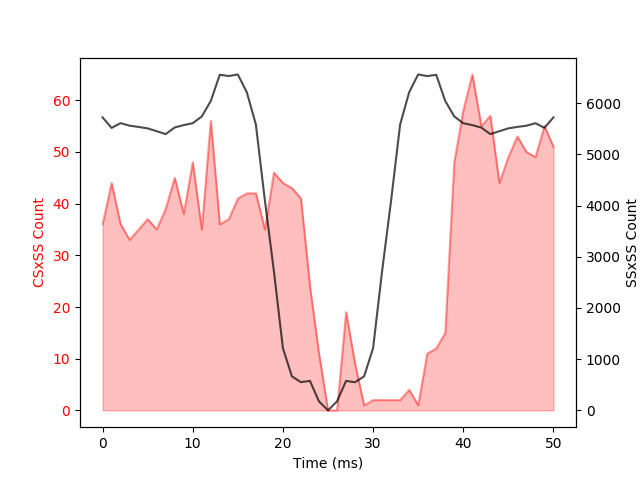

Text(0, 0.5, 'SSxSS Count')

In [76]:
plt.figure()
plt.plot(xcor_vect, 'r', alpha=0.35)
plt.yticks(color='r')
plt.fill_between(np.arange(0,2*window + 1), xcor_vect, color='r', alpha=0.25)
plt.ylabel('CSxSS Count', color = 'r')
plt.xlabel('Time (ms)')

plt.twinx()
plt.plot(acor_vect, 'k', alpha=0.70)
plt.yticks(color='k')
plt.ylabel('SSxSS Count', color='k')
# plt.fill_between(acor_ret[0], 0, acor_ret[1] , color='g', alpha=0.25)


In [79]:
class test1:
    def __init__(self):
        self.a = np.array([1,2,3])
        self.a2 = [1,2,3]
    
    def func1(self):
        b = self.a
        b[0] = -1
        b2 = self.a2
        b2[0] = -1
        return b, b2

t1 = test1()
print(t1.a)
print(t1.a2)
print(t1.func1())
print(t1.a)
print(t1.a2)